In [22]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import pickle
import treegp
import george
from george import kernels
%matplotlib widget

In [24]:
def timer(f):
    import functools

    @functools.wraps(f)
    def f2(*args, **kwargs):
        import time
        import inspect

        t0 = time.time()
        result = f(*args, **kwargs)
        t1 = time.time()
        fname = repr(f).split()[1]
        print("time for %s = %.4f" % (fname, t1 - t0))
        return result

    return f2

class gp_george():

    def __init__(self, std=2, correlation_length=1., white_noise=0.):
        
        self.std = std
        self.l = correlation_length
        self.white_noise  = white_noise

    @timer
    def fit(self, x, y):
        alpha = self.white_noise**2
        kernel = self.std**2 * kernels.ExpSquaredKernel(self.l, ndim=2)
        self.gp = george.GP(kernel, fit_kernel=False, solver=george.HODLRSolver, seed=42)
        self.gp.compute(x, yerr=alpha)
        self._y = y

    @timer
    def predict(self, x):
        y_pred = self.gp.predict(self._y, x, return_var=False, return_cov=False)
        return y_pred


class gp_treegp():

    def __init__(self, std=2, correlation_length=1., white_noise=0.):
        
        self.std = std
        self.l = correlation_length
        self.white_noise  = white_noise


    @timer
    def fit(self, x, y):
        # alpha = self.white_noise**2
        # kernel = self.std**2 * kernels.ExpSquaredKernel(self.l, ndim=2)
        # self.gp = george.GP(kernel, fit_kernel=False, solver=george.HODLRSolver, seed=42)
        # self.gp.compute(x, yerr=alpha)
        # self._y = y

        KERNEL = '%.2f**2 * RBF(%f)'%((self.std, self.l))
        self.gp = treegp.GPInterpolation(
                kernel=KERNEL,
                optimizer='none',
                normalize=True,
                p0=[3000.0, 0.0, 0.0],
                white_noise=self.white_noise,
        )
        self.gp.initialize(x, y)
        self.gp.solve()

    @timer
    def predict(self, x):
        y_pred = self.gp.predict(x)
        return y_pred    

In [4]:
dic = pickle.load(open("../data/out_test_0", "rb"))
dic2 = pickle.load(open("../data/out_test_1", "rb"))

In [5]:
A = dic['in']['maskedImage']

In [6]:
dic2['in']['fwhm']

1.0

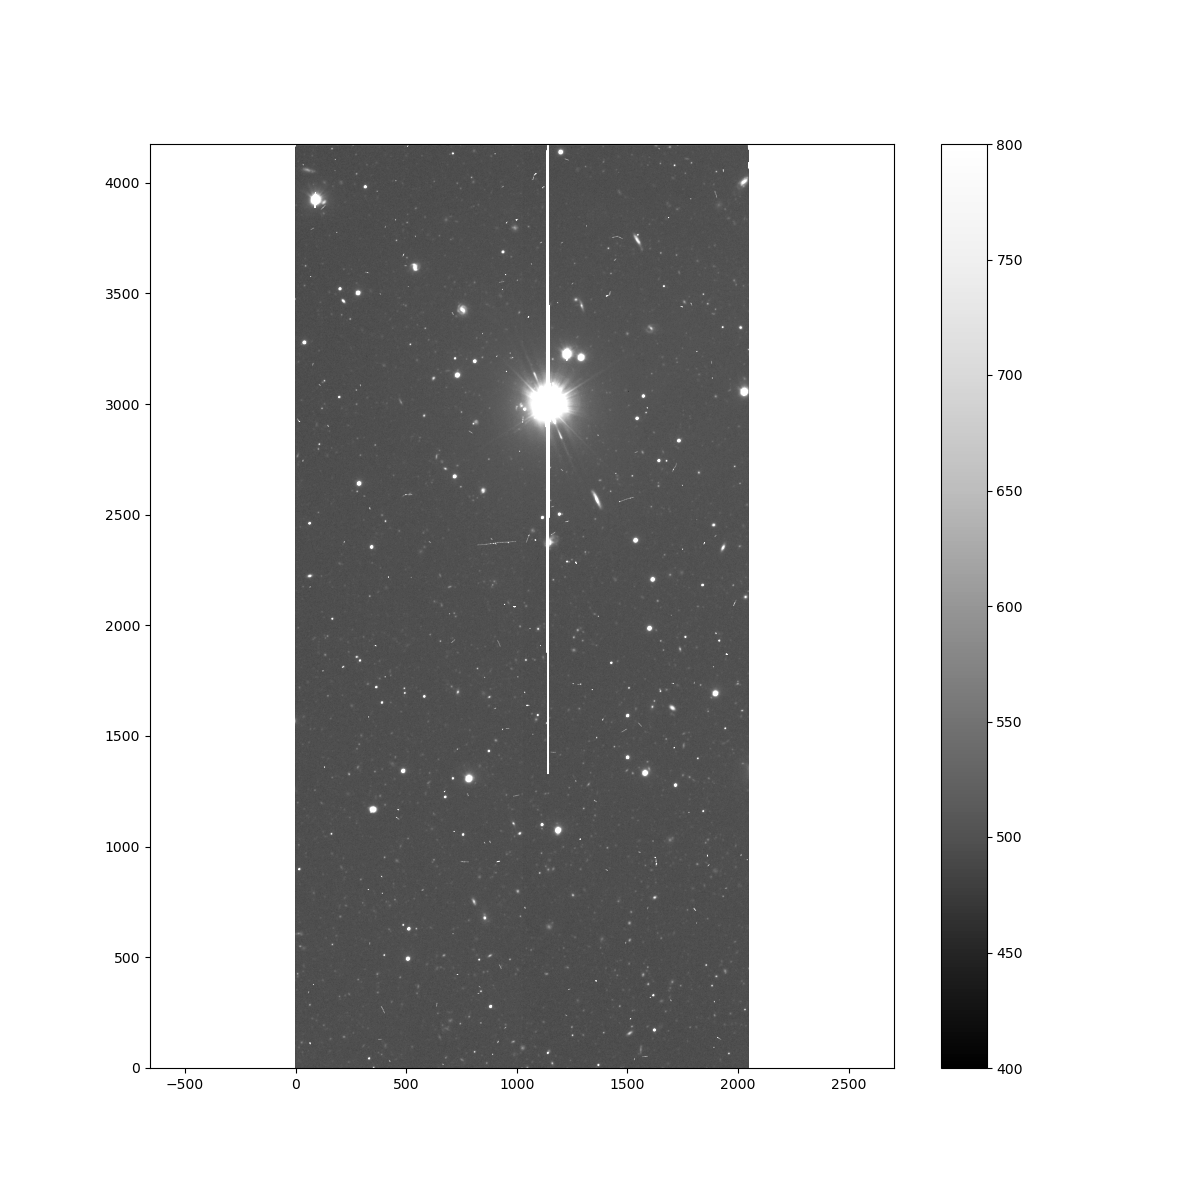

In [7]:
plt.figure(figsize=(12,12))
#plt.imshow(A.getImage().array,  norm=LogNorm(vmin=200, vmax=30000), cmap=plt.cm.Greys_r)
plt.imshow(A.getImage().array,  vmin=400, vmax=800, cmap=plt.cm.Greys_r)
plt.colorbar()
plt.axis('equal')
plt.gca().invert_yaxis()

In [8]:
B = dic['out']['maskedImage']

(-0.5, 2047.5, 4175.5, -0.5)

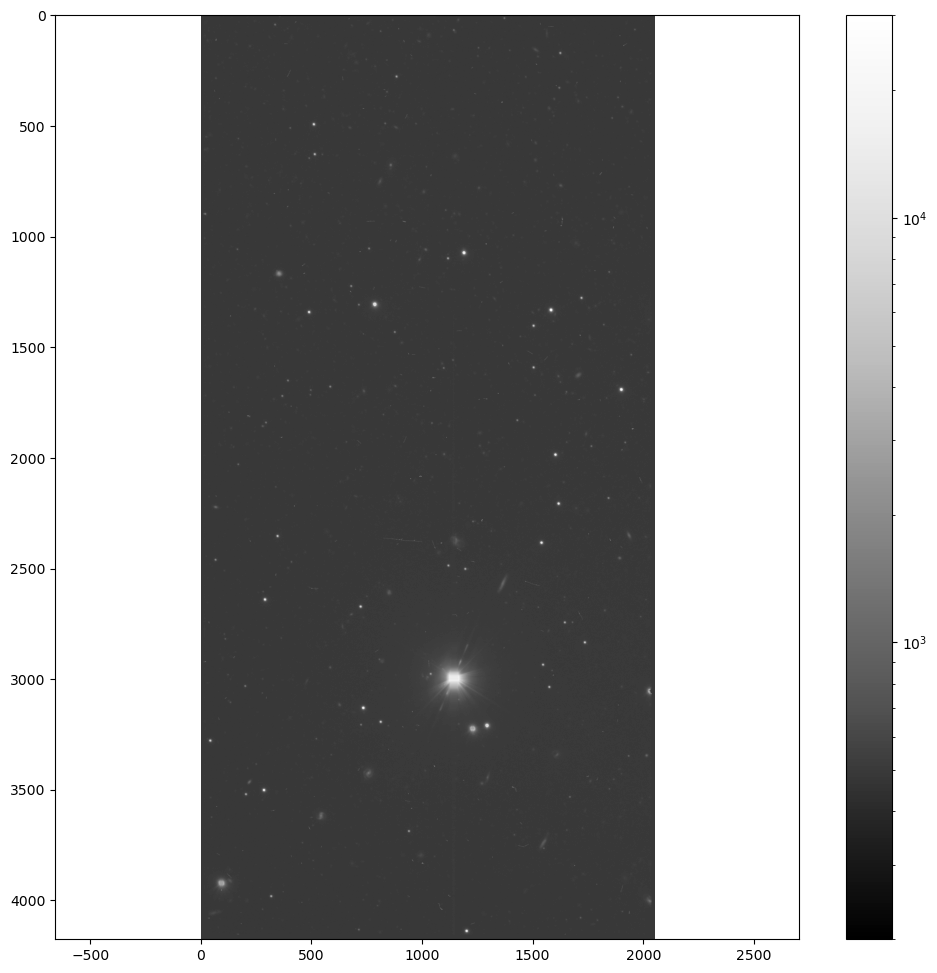

In [7]:
plt.figure(figsize=(12,12))
plt.imshow(B.getImage().array,  norm=LogNorm(vmin=200, vmax=30000), cmap=plt.cm.Greys_r)
plt.colorbar()
plt.axis('equal')

(-0.5, 99.5, -0.5, 99.5)

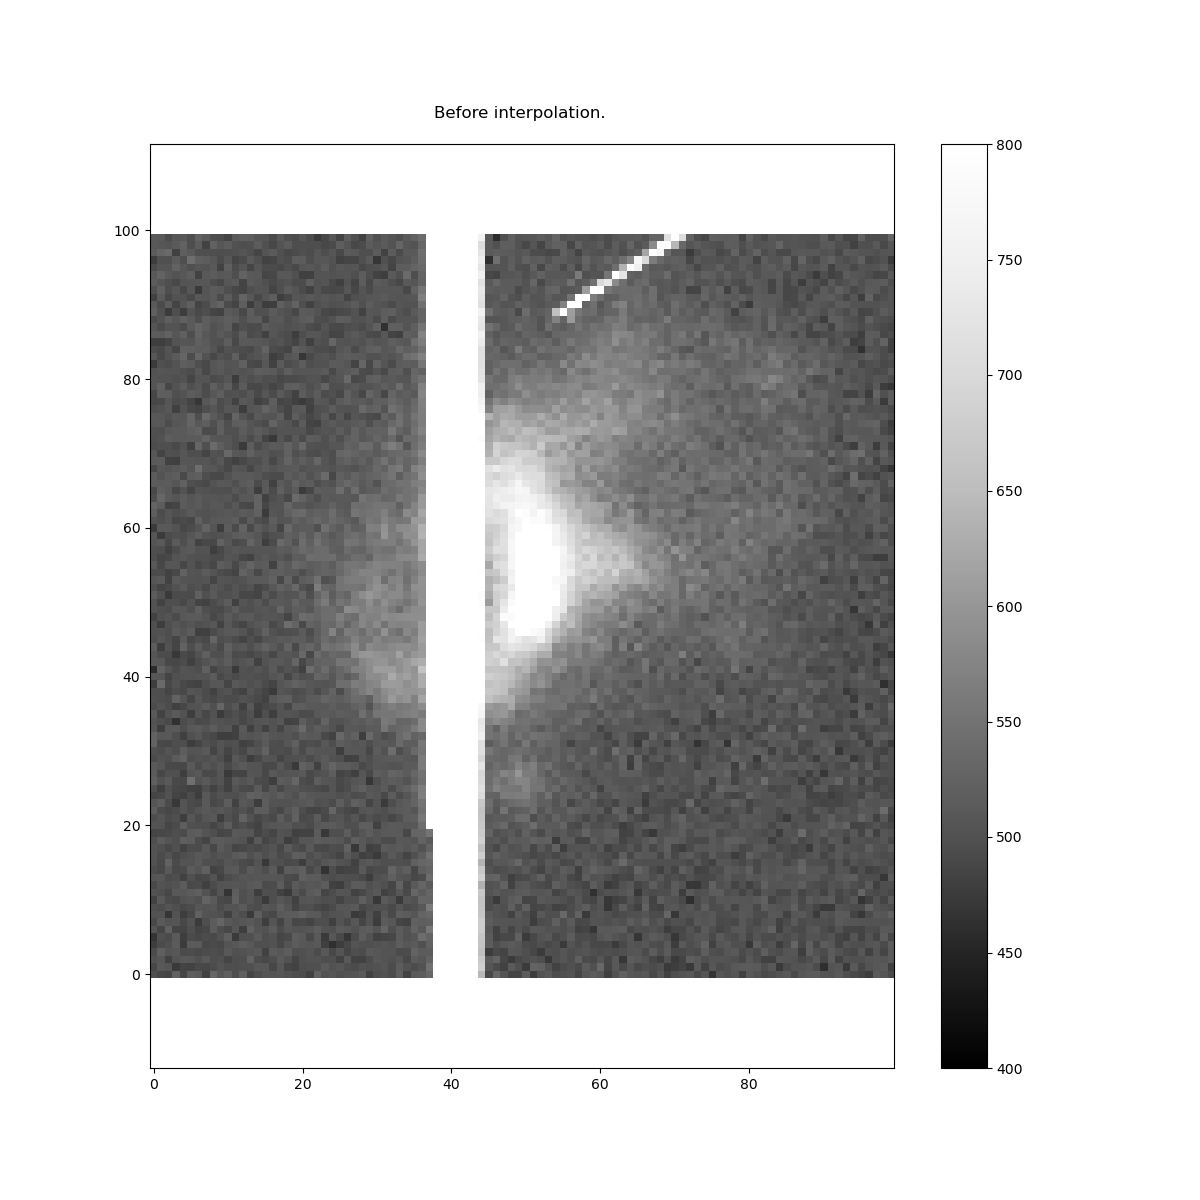

In [11]:
plt.figure(figsize=(12,12))
plt.title('Before interpolation. \n ')
plt.imshow(A.getImage().array[2320:2420, 1100:1200],  vmin=400, vmax=800, cmap=plt.cm.Greys_r)
plt.colorbar()
plt.gca().invert_yaxis()
plt.axis('equal')
#plt.savefig('1_interp_test_0.png')

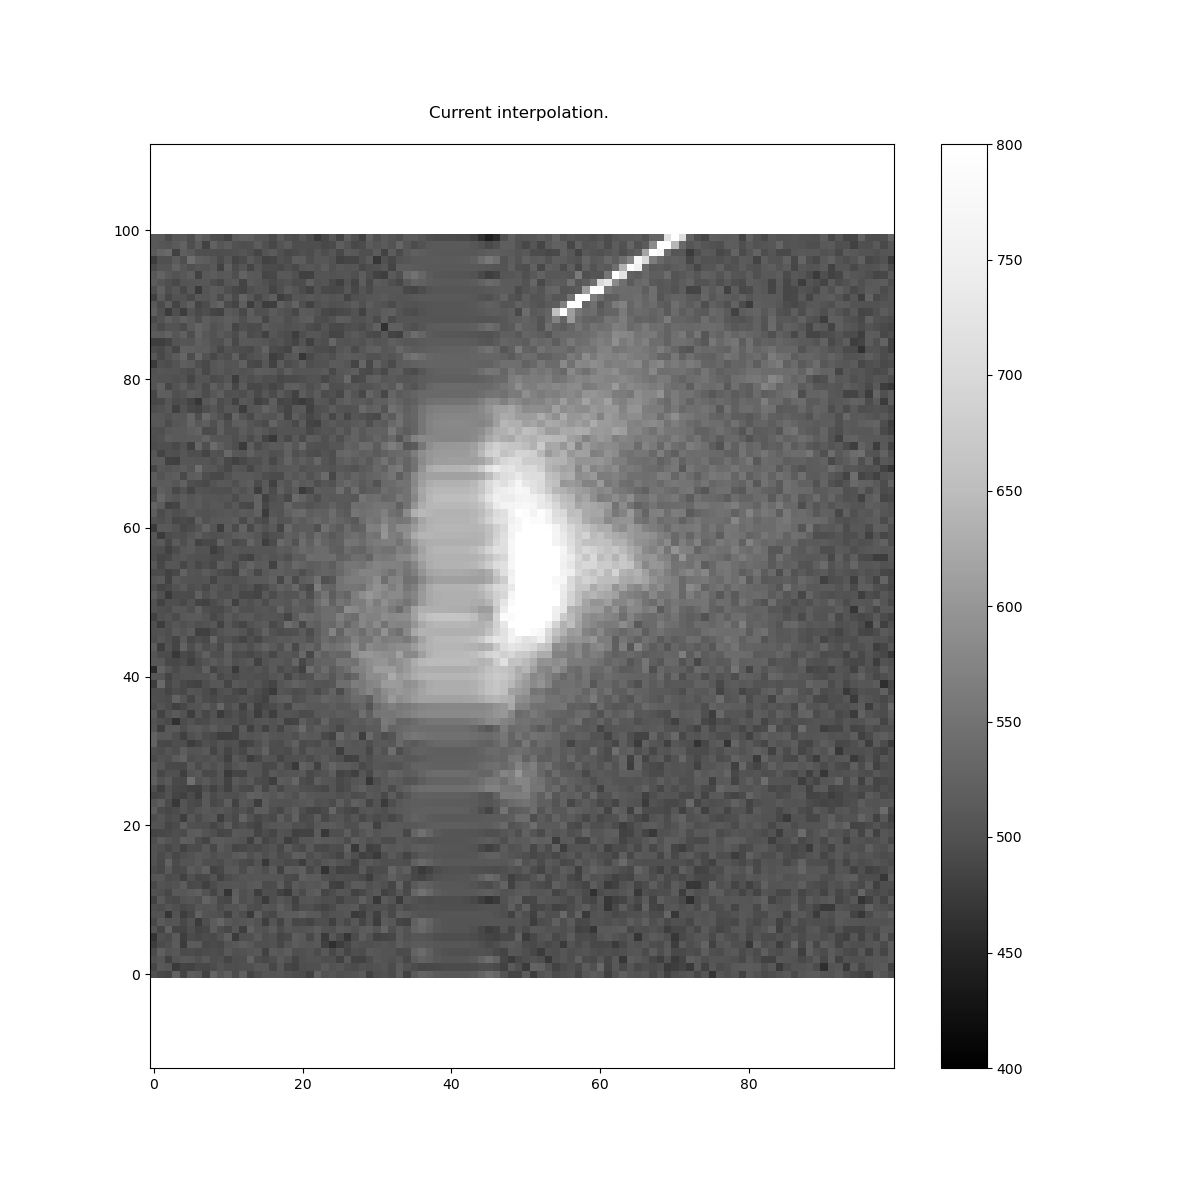

In [10]:
plt.figure(figsize=(12,12))
plt.title('Current interpolation. \n ')
plt.imshow(B.getImage().array[2320:2420, 1100:1200], vmin=400, vmax=800, cmap=plt.cm.Greys_r)
plt.colorbar()
plt.axis('equal')
plt.gca().invert_yaxis()
#plt.savefig('1_interp_test_1.png')

In [12]:
data = A.getImage().array[2320:2420, 1100:1200]
data_var = A.getVariance().array[2320:2420, 1100:1200]
x = np.arange(data.shape[0])  # Columns represent the x-axis
y = np.arange(data.shape[1])  # Rows represent the y-axis
X, Y = np.meshgrid(x, y)  # Create the mesh grid
X = X.reshape(-1)
Y = Y.reshape(-1)
Coords = np.array(([X, Y])).T

In [13]:
mask = A.getMask().array
mask_cropped = mask[2320:2420, 1100:1200]
Filter = mask_cropped.reshape(-1) < 1

data_train = data.reshape(-1)[Filter]
var_train = data_var.reshape(-1)[Filter]
Coords_train = Coords[Filter]
Coords_val = Coords[~Filter]

time for gp_treegp.fit = 0.0010
time for gp_treegp.predict = 2.8560


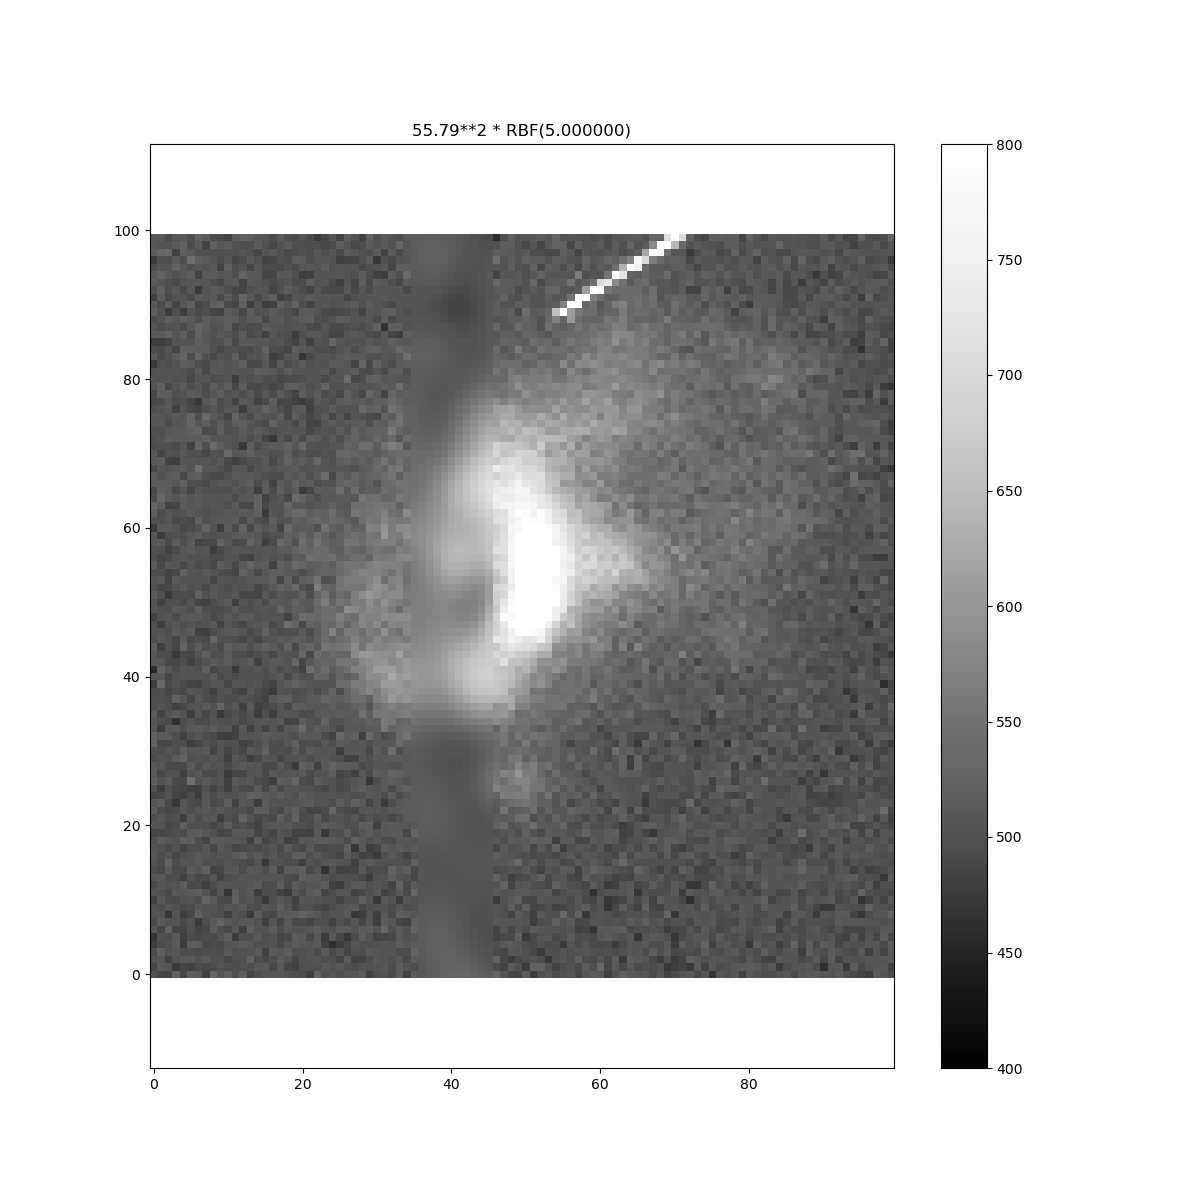

In [25]:
std = np.sqrt(np.var(data_train) - np.mean(var_train))

gpt = gp_treegp(std=std, correlation_length=5., white_noise=np.mean(np.sqrt(var_train)))
gpt.fit(Coords_train, data_train)
yt = gpt.predict(Coords_val)

gp_interp = np.zeros_like(data.reshape(-1))
gp_interp[Filter] = data_train
gp_interp[~Filter] = data_val
gp_interp = gp_interp.reshape(np.shape(data))

plt.figure(figsize=(12,12))
plt.title(KERNEL)
plt.imshow(gp_interp, vmin=400, vmax=800, cmap=plt.cm.Greys_r)
plt.colorbar()
plt.axis('equal')
plt.gca().invert_yaxis()
#plt.savefig('1_interp_test_2.png')
#plt.savefig('%i_rbf_gp_interp.png'%(i+1))
#plt.close()

time for gp_george.fit = 0.0893
time for gp_george.predict = 0.2143


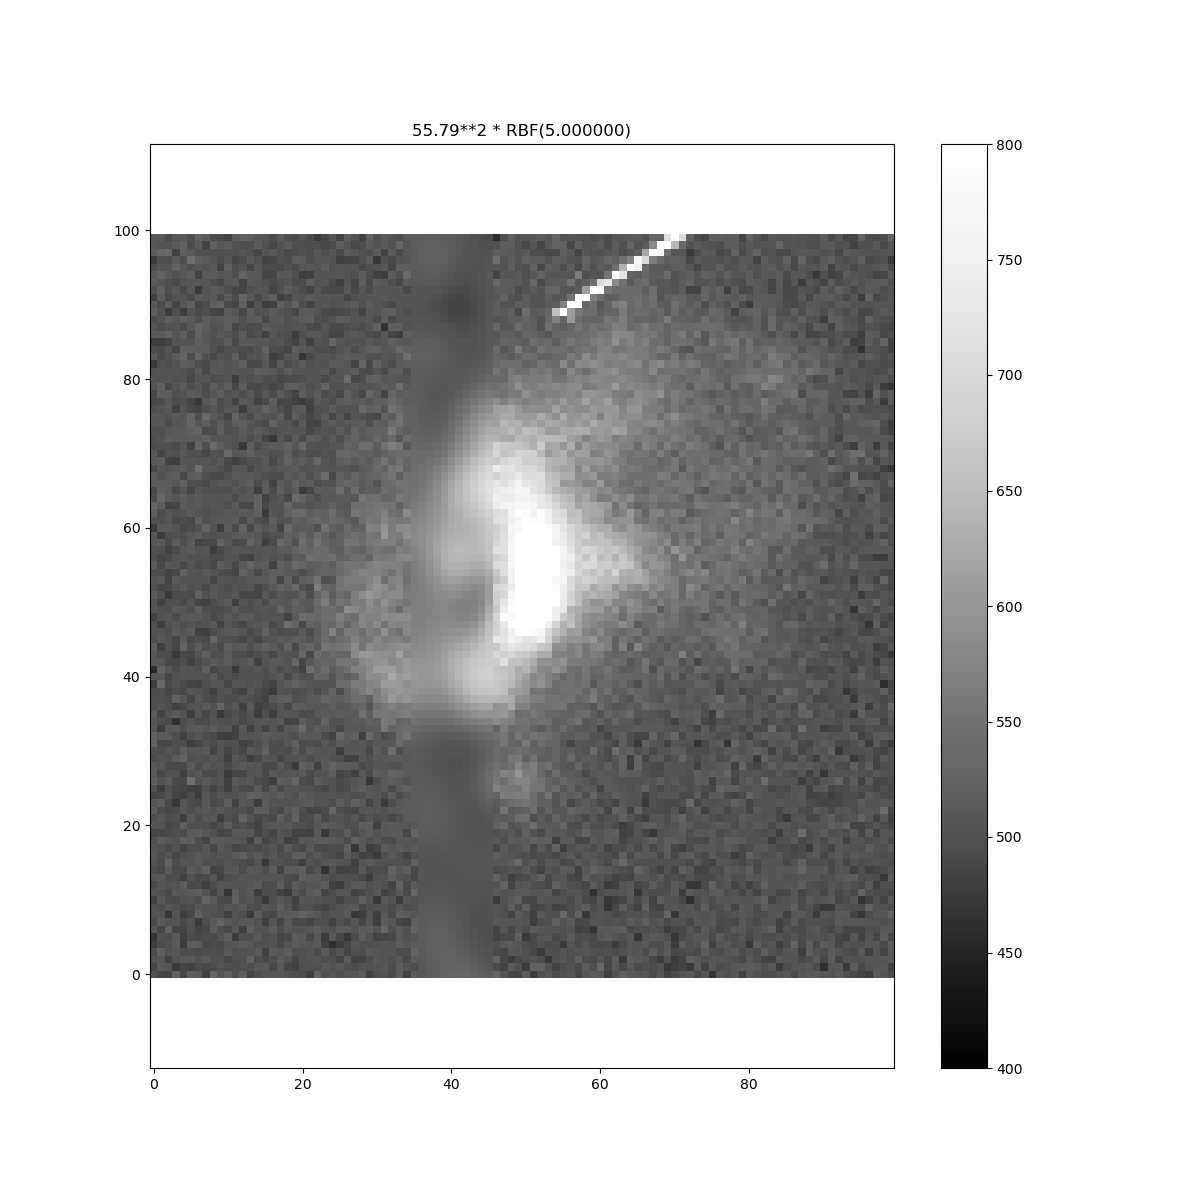

In [26]:
std = np.sqrt(np.var(data_train) - np.mean(var_train))

gpg = gp_george(std=std, correlation_length=5., white_noise=np.mean(np.sqrt(var_train)))
gpg.fit(Coords_train, data_train)
yt = gpg.predict(Coords_val)

gp_interp = np.zeros_like(data.reshape(-1))
gp_interp[Filter] = data_train
gp_interp[~Filter] = data_val
gp_interp = gp_interp.reshape(np.shape(data))

plt.figure(figsize=(12,12))
plt.title(KERNEL)
plt.imshow(gp_interp, vmin=400, vmax=800, cmap=plt.cm.Greys_r)
plt.colorbar()
plt.axis('equal')
plt.gca().invert_yaxis()
#plt.savefig('1_interp_test_2.png')
#plt.savefig('%i_rbf_gp_interp.png'%(i+1))
#plt.close()